In [21]:
import pymc as pm
import numpy as np
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import math
import scipy.stats
from statsmodels.stats import weightstats
import matplotlib.mlab as mlab
from pymc.Matplot import plot as mcplot
import csv

In [22]:
## transfer some data into a form we can work with
class Sample:
    def __init__(self, samples, mean):
        self.samples = int(samples)
        self.mean = mean
        self.successes = int(round(samples * mean))
        self.failures = int(round(samples * (1-mean)))
        self.observations = np.array([0]*self.failures + [1]*self.successes)
        np.random.shuffle(self.observations)
        
    def __str__(self):
        return "Sample: samples={samples:d}, mean={mean:.3f}".format(samples=self.samples, mean=self.mean)
    def __unicode__(self):
        return "Sample: samples={samples:d}, mean={mean:.3f}".format(samples=self.samples, mean=self.mean)
    def __repr__(self):
        return "Sample: samples={samples:d}, mean={mean:.3f}".format(samples=self.samples, mean=self.mean)
        
    @classmethod
    def from_success_failure(self, successes, failures):
        self.samples = successes + failures
        self.successes = successes
        self.failures = failures
        self.observations = np.array([0]*self.failures + [1]*self.successes)
        np.random.shuffle(self.observations) # inplace
        self.mean = np.mean(self.observations)
        
class BaysianSummary:
    def __init__(self, trace):
        self.trace = trace
        self.data = trace[:]
        self.posterior_mean = self.data.mean()
        self.posterior_5th  = np.percentile(self.data, 5)
        self.posterior_95th  = np.percentile(self.data, 95)
        self.p_better_than = (self.data < 0).mean()
        self.p_worse_than = (self.data > 0).mean()
    
    def __str__(self):
        return "BaysianSummary: posterior_mean=%.3f" % (self.posterior_mean,)
    def __unicode__(self):
        return "BaysianSummary: posterior_mean=%.3f" % (self.posterior_mean,)
    def __repr__(self):
        return "BaysianSummary: posterior_mean=%.3f" % (self.posterior_mean,)
    
        
class FrequentistSummary:
    def __init__(self, delta, p):
        self.delta = delta
        self.p = p
        self.sig = p < 0.05
        
    def __str__(self):
        return "FrequentistSummary: delta=%.3f" % (self.delta,)
    def __unicode__(self):
        return "FrequentistSummary: delta=%.3f" % (self.delta,)
    def __repr__(self):
        return "FrequentistSummary: delta=%.3f" % (self.delta,)

In [23]:
# Set up the pymc model. Again assume Uniform priors for p_A and p_B.
def run_bayes(sample1, sample2):

    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)


    # Define the deterministic delta function. This is our unknown of interest.
    @pm.deterministic
    def delta(p_A=p_A, p_B=p_B):
        return p_A - p_B

    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, value=sample1.observations, observed=True)
    obs_B = pm.Bernoulli("obs_B", p_B, value=sample2.observations, observed=True)

    model = pm.Model([p_A, p_B, delta, obs_A, obs_B])
    map_ = pm.MAP(model)
    map_.fit()
    mcmc = pm.MCMC(model)
    mcmc.sample(20000, 1000)
    
    return mcmc.trace("delta")

In [24]:
def frequentist_from_samples(sample1, sample2):
    mu1 = sample1.observations.mean()
    mu2 = sample2.observations.mean()
    SE1 = mu1 * (1-mu1) / math.sqrt(len(sample1.observations))
    SE2 = mu2 * (1-mu2) / math.sqrt(len(sample2.observations))
    z = (mu1 - mu2) / (SE1**2 + SE2**2)**0.5
    p = scipy.stats.norm.sf(abs(z))*2
    delta = mu1 - mu2
    return FrequentistSummary(delta, p)

In [25]:
# control_means = [0.003, 0.01, 0.03, 0.1, 0.3]
# proportional_differences = [0.01, 0.03, 0.1, 0.2]
# n_samples = [100, 1000, 10000, 100000, 1000000]

control_means = [0.03, 0.1]
proportional_differences = [0.03, 0.1]
n_samples = [100, 1000, 10000]
samples_means = [(muC, muC*(1+propdiff)) 
                 for muC in control_means 
                 for propdiff in proportional_differences]

sample_pairs = [(Sample(samples, muV), Sample(samples, muC))
                for (muC, muV) in samples_means
                for samples in n_samples
               if abs(muV-muC)*samples >= 1] # so that the control and variant are actually different

sample_pairs

[(Sample: samples=10000, mean=0.031, Sample: samples=10000, mean=0.030),
 (Sample: samples=1000, mean=0.033, Sample: samples=1000, mean=0.030),
 (Sample: samples=10000, mean=0.033, Sample: samples=10000, mean=0.030),
 (Sample: samples=1000, mean=0.103, Sample: samples=1000, mean=0.100),
 (Sample: samples=10000, mean=0.103, Sample: samples=10000, mean=0.100),
 (Sample: samples=100, mean=0.110, Sample: samples=100, mean=0.100),
 (Sample: samples=1000, mean=0.110, Sample: samples=1000, mean=0.100),
 (Sample: samples=10000, mean=0.110, Sample: samples=10000, mean=0.100)]

In [26]:
outputs = [(BaysianSummary(run_bayes(sample1, sample2)), frequentist_from_samples(sample1, sample2)) 
           for (sample1, sample2) in sample_pairs]

 [-----------------100%-----------------] 20000 of 20000 complete in 18.1 sec

In [27]:
[(bayes.posterior_mean,freq.delta) 
 for (bayes, freq) in outputs]

[(0.00091866121557773706, 0.00090000000000000149),
 (0.0029537773231341547, 0.0030000000000000027),
 (0.0029349714468093905, 0.0030000000000000027),
 (0.0034890048330028425, 0.0029999999999999888),
 (0.0030570845722250363, 0.0029999999999999888),
 (0.0094229009210664363, 0.009999999999999995),
 (0.0097999435350480182, 0.009999999999999995),
 (0.010019829847809976, 0.009999999999999995)]

In [28]:
output_for_csv = [(b.posterior_5th, b.posterior_mean, b.posterior_95th, f.delta, f.sig) for (b,f) in outputs]
output_for_csv

[(-0.0030308344727380254,
  0.00091866121557773706,
  0.0049666050199262193,
  0.00090000000000000149,
  True),
 (-0.0098320248407649611,
  0.0029537773231341547,
  0.016230115046020441,
  0.0030000000000000027,
  True),
 (-0.0010536364766883868,
  0.0029349714468093905,
  0.0069088213649766625,
  0.0030000000000000027,
  True),
 (-0.01919964207683789,
  0.0034890048330028425,
  0.026378533261440268,
  0.0029999999999999888,
  False),
 (-0.0040744991940243197,
  0.0030570845722250363,
  0.010023638645925717,
  0.0029999999999999888,
  True),
 (-0.062643997621567693,
  0.0094229009210664363,
  0.08268633319872222,
  0.009999999999999995,
  False),
 (-0.012847755707242725,
  0.0097999435350480182,
  0.032814286275682954,
  0.009999999999999995,
  True),
 (0.0027767252786252,
  0.010019829847809976,
  0.016832539827152826,
  0.009999999999999995,
  True)]

In [29]:
with open("/home/harry/Documents/many_sumulated_situations.csv", "w") as the_file:
    writer = csv.writer(the_file, delimiter=',')
    writer.writerow(["b.posterior_5th", "b.posterior_mean", "b.posterior_95th", "f.delta", "f.sig"])
    writer.writerows(output_for_csv)

Plotting delta


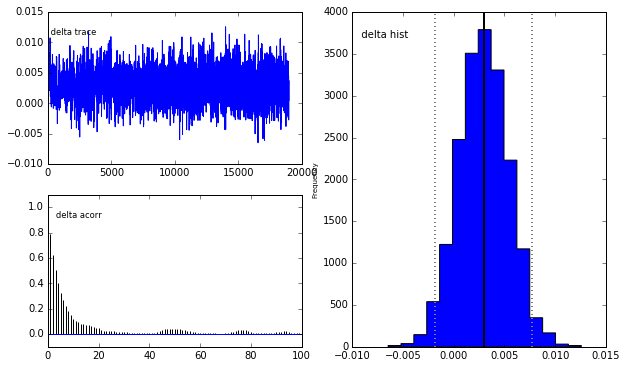

In [32]:
mcplot(outputs[2][0].trace)